In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.figure_factory as ff
import plotly.graph_objects as go
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.model_selection import cross_validate
import numpy as np

In [2]:
pd.options.display.max_columns = None

#### Load data

In [3]:
PATH = './data_tesco/'

GROCERY_WARD = 'year_osward_grocery.csv'
GROCERY_BOROUGH = 'year_borough_grocery.csv'

DIABETES_WARD = 'diabetes_estimates_osward_2016.csv'
OBESITY_BOROUGH = 'london_obesity_borough_2012.csv'
OBESITY_HOSP_BOROUGH = 'obesity_hospitalization_borough_2016.csv'
CHILD_OBESITY_WARD = 'child_obesity_london_ward_2013-2014.csv'

MAPPING_BOROUGH_WARD = 'Mapping-template-london-ward-map-2018.xls'
MAPPING_CODE_BOROUGH = 'Mapping-template-for-London-boroughs.xls'

BOUNDARIES_BOROUGH = 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'

Load groceries in boroughs and wards

In [4]:
groceries_borough = pd.read_csv(PATH + GROCERY_BOROUGH, sep = ',', header = 0)
groceries_ward = pd.read_csv(PATH + GROCERY_WARD, sep = ',', header = 0)
# Consider representativeness?
groceries_borough = groceries_borough[groceries_borough['representativeness_norm'] >= 0.1]
groceries_ward = groceries_ward[groceries_ward['representativeness_norm'] >= 0.1]

Load ward to borough mapping

In [5]:
mapping_ward_to_borough = pd.read_excel(MAPPING_BOROUGH_WARD, sheet_name = 'Ward Thematic Map',usecols = [0, 1, 2],
                                        names = ['Ward Code', 'Ward name', 'Borough name'])
mapping_code_to_borough = pd.read_excel(MAPPING_CODE_BOROUGH, sheet_name = 'Borough Thematic Map',usecols = [1, 2],
                                       names = ['Borough Code', 'Borough name'])
mapping_ward_to_borough = mapping_ward_to_borough.merge(mapping_code_to_borough, on = 'Borough name')
mapping_ward_to_borough = mapping_ward_to_borough.drop(columns = ['Ward name', 'Borough name'])

Load health data

Some of the data (diabetes and child obesity) are only available for borough, thus we average all wards part of a same borough and map the data to the corresponding borough.

In [6]:
# Diabetes
diabetes_ward = pd.read_csv(PATH + DIABETES_WARD, sep = ',', header = 0)
diabetes_ward = diabetes_ward.merge(mapping_ward_to_borough, left_on = 'area_id', right_on = 'Ward Code')
diabetes_ward = diabetes_ward.drop(columns = ['Ward Code'])
diabetes_borough = diabetes_ward.groupby(['Borough Code'], as_index = False).mean()
len(diabetes_borough)

28

In [7]:
# Obesity
obesity_borough = pd.read_csv(PATH + OBESITY_BOROUGH, sep = ',', header = 0)
len(obesity_borough)

33

In [8]:
# Child obesity ward
child_obesity_ward = pd.read_csv(PATH + CHILD_OBESITY_WARD, sep = ',', header = 0)
to_drop = child_obesity_ward[ (child_obesity_ward['prevalence_overweight_reception'] == 'na')
                             | (child_obesity_ward['prevalence_overweight_y6'] == 'na')
                            | (child_obesity_ward['prevalence_obese_reception'] == 'na')
                            | (child_obesity_ward['prevalence_obese_y6'] == 'na')].index
child_obesity_ward.drop(to_drop , inplace=True)
child_obesity_ward = child_obesity_ward.merge(mapping_ward_to_borough, left_on = 'area_id', right_on = 'Ward Code')
child_obesity_ward = child_obesity_ward.drop(columns = ['Ward Code'])
child_obesity_ward = child_obesity_ward.astype({'number_reception_measured': 'float64',
          'number_y6_measured': 'float64',
          'prevalence_overweight_reception': 'float64',
          'prevalence_overweight_y6': 'float64',
          'prevalence_obese_reception': 'float64',
          'prevalence_obese_y6': 'float64'})
child_obesity_borough = child_obesity_ward.groupby(['Borough Code'], as_index = False).mean()
len(child_obesity_borough)

28

In [9]:
# Obesity hospitalization
obesity_hosp_borough = pd.read_csv(PATH + OBESITY_HOSP_BOROUGH, sep = ',', header = 0)
to_drop = obesity_hosp_borough[obesity_hosp_borough['total_hospitalizations'] == 'na' ].index
obesity_hosp_borough.drop(to_drop , inplace=True)
obesity_hosp_borough = obesity_hosp_borough.astype({'total_hospitalizations': 'float64',
          'total_bariatric': 'float64',
          'prevalence_hospitalizations': 'float64',
          'prevalence_bariatric': 'float64'})
len(obesity_hosp_borough)

31

Merge data for wards

In [10]:
merged = pd.merge(diabetes_ward, groceries_ward, how = 'inner', left_index = False, on='area_id')
merged_ward = pd.merge(merged, child_obesity_ward, how = 'inner', left_index = False, on='area_id')
#merged_ward.head()

Merge data for boroughs

In [11]:
merged = pd.merge(obesity_hosp_borough, groceries_borough, how = 'inner', left_index = False,
                  on='area_id')
merged = pd.merge(merged, obesity_borough, how = 'inner', left_index = False, left_on='area_id',
                         right_on = 'oslaua')
merged = pd.merge(merged, child_obesity_borough, how = 'inner', left_index = False, left_on='area_id',
                         right_on = 'Borough Code')
merged_borough = pd.merge(merged, diabetes_borough, how = 'inner', left_index = False, left_on='area_id',
                         right_on = 'Borough Code')
merged_borough.head()
len(merged_borough)
merged_borough.head()

area_id  total_hospitalizations  total_bariatric  \
0  E09000002                    34.0             25.0   
1  E09000003                    94.0             61.0   
2  E09000005                   105.0             70.0   
3  E09000006                    60.0             39.0   
4  E09000007                    61.0             41.0   

   prevalence_hospitalizations  prevalence_bariatric      weight  \
0                        0.018                 0.014  421.304125   
1                        0.026                 0.017  407.170491   
2                        0.036                 0.022  434.324141   
3                        0.018                 0.012  319.336273   
4                        0.025                 0.016  348.420414   

   weight_perc2.5  weight_perc25  weight_perc50  weight_perc75  \
0            32.5          165.6          300.0          500.0   
1            40.0          180.0          320.0          500.0   
2            40.0          175.0          325.0          500.0   
3            30.0          135.0          250.0          400.0   
4            35.0          150.0          260.0          450.0   

   weight_perc97.5  weight_std  weight_ci95      volume  volume_perc2.5  \
0           1500.0  597.994271     0.828993  122.341294            11.0   
1           1160.0  443.644324     0.171615  114.933771            10.1   
2           1500.0  616.087316     0.354492  128.930369            11.0   
3           1000.0  347.979651     0.458224  101.105159            12.5   
4           1000.0  370.640809     0.373270  102.525979            12.0   

   volume_perc25  volume_perc50  volume_perc75  volume_perc97.5  volume_std  \
0           47.1           90.0          175.0            340.8  115.859833   
1           50.0           75.0          160.0            340.8  102.318670   
2           50.0          100.0          200.0            340.8  111.360311   
3           47.3           75.0          113.6            340.8   88.178240   
4           50.0           75.0          113.6            340.8   85.227409   

   volume_ci95       fat  fat_perc2.5  fat_perc25  fat_perc50  fat_perc75  \
0     0.351870  9.209959          0.0         0.2         2.4        13.9   
1     0.088928  8.594464          0.0         0.2         1.8        12.0   
2     0.134100  8.962466          0.0         0.2         2.0        13.0   
3     0.243147  9.123054          0.0         0.2         2.3        14.2   
4     0.183343  8.801149          0.0         0.2         1.8        13.0   

   fat_perc97.5    fat_std  fat_ci95  saturate  saturate_perc2.5  \
0          48.2  14.478662  0.016131  3.596834               0.0   
1          50.5  14.594997  0.004558  3.407353               0.0   
2          50.5  14.806922  0.006800  3.559913               0.0   
3          44.8  13.726369  0.014451  3.556924               0.0   
4          48.1  14.310349  0.011609  3.503451               0.0   

   saturate_perc25  saturate_perc50  saturate_perc75  saturate_perc97.5  \
0              0.1              0.8              4.1               20.5   
1              0.1              0.4              3.4               21.5   
2              0.1              0.6              3.8               21.4   
3              0.1              0.8              4.1               20.0   
4              0.1              0.5              3.6               21.5   

   saturate_std  saturate_ci95      salt  salt_perc2.5  salt_perc25  \
0      6.466539       0.007205  0.603081           0.0         0.03   
1      6.770946       0.002114  0.567211           0.0         0.01   
2      6.802470       0.003124  0.570477           0.0         0.01   
3      6.286297       0.006618  0.563583           0.0         0.01   
4      6.711357       0.005445  0.540383           0.0         0.01   

   salt_perc50  salt_perc75  salt_perc97.5  salt_std  salt_ci95      sugar  \
0         0.20         0.80            2.4  2.168270   0.002416  10.793244   
1         0.11         0

Load and merge boundaries

In [12]:
map_borough = gpd.read_file(BOUNDARIES_BOROUGH)
merged = map_borough.merge(merged_borough, left_on = 'GSS_CODE', right_on = 'area_id', how = 'inner')

#### Plot function

In [13]:
def plot_london(variable, merged_borough):
    MAPBOX_ACCESSTOKEN = 'pk.eyJ1Ijoic29zbzk0IiwiYSI6ImNraTdwem80MDFsNXEyc3FzeGMxOHpoZGkifQ.coIFQU-pN6pZJi0GuXnLVw'
    merged = map_borough.merge(merged_borough, left_on = 'GSS_CODE', right_on = 'area_id', how = 'inner')
    merged = merged.to_crs(epsg=4326) # convert the coordinate reference system to lat/long
    lga_json = merged.__geo_interface__ #covert to geoJSON
    zmin = merged[variable].min()
    zmax = merged[variable].max()
    name = merged['NAME']

    # Set the data for the map
    data = go.Choroplethmapbox(
            geojson = lga_json,             #this is your GeoJSON
            locations = merged.index,    #the index of this dataframe should align with the 'id' element in your geojson
            z = merged[variable], #sets the color value
            text = merged.NAME,    #sets text for each shape
            colorbar=dict(thickness=20, ticklen=3, tickformat='',outlinewidth=0), #adjusts the format of the colorbar
            marker_line_width=1, marker_opacity=0.7, colorscale="Viridis", #adjust format of the plot
            zmin=zmin, zmax=zmax,           #sets min and max of the colorbar
            hovertemplate = "<b>%{text}</b><br>" +
                        "%{z:.0%}<br>" +
                        "<extra></extra>")  # sets the format of the text shown when you hover over each shape

    # Set the layout for the map
    layout = go.Layout(
        title = {'text': variable,
                'font': {'size':24}},       #format the plot title
        mapbox1 = dict(
            domain = {'x': [0, 1],'y': [0, 1]}, 
            center = dict(lat=51.509865 , lon=-0.118092),
            accesstoken = MAPBOX_ACCESSTOKEN, 
            zoom = 8),                      
        autosize=True,
        height=650,
        margin=dict(l=0, r=0, t=40, b=0))

    # Generate the map
    fig=go.Figure(data=data, layout=layout)
    fig.show()

## Are the areas with most diabetes are the same as areas with obesity, or child obesity?

Check if there's a correlation between the indicators

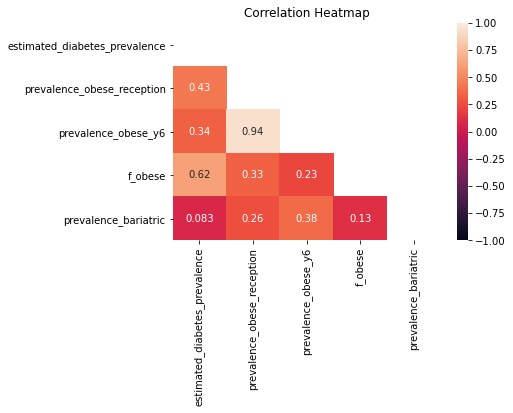

In [14]:
indicators = ['estimated_diabetes_prevalence', 'prevalence_obese_reception', 'prevalence_obese_y6','f_obese', 'prevalence_bariatric']
df = merged_borough[indicators]

mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, mask = mask, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

Check if those indicators are correlated with any food habits

In [15]:
# We partition 'types' of food habits
f_nutrients = ['f_energy_fat', 'f_energy_saturate', 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre',
            'f_energy_alcohol']
energy_nutrients = ['energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein', 'energy_carb', 'energy_fibre',
            'energy_alcohol']
f_food_categories = ['f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains',
                   'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits',
                   'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine']
features = f_nutrients + energy_nutrients + f_food_categories

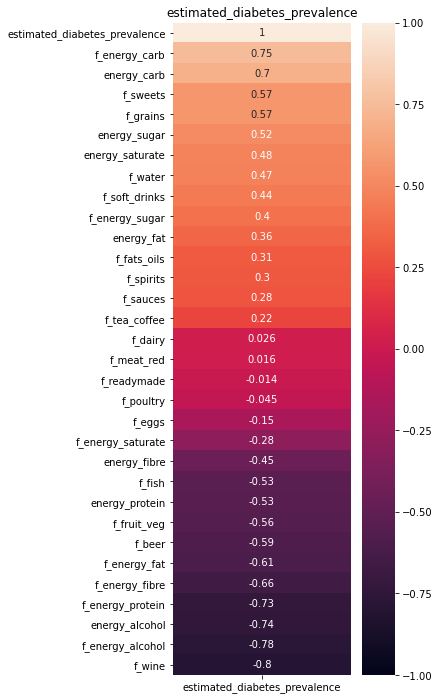

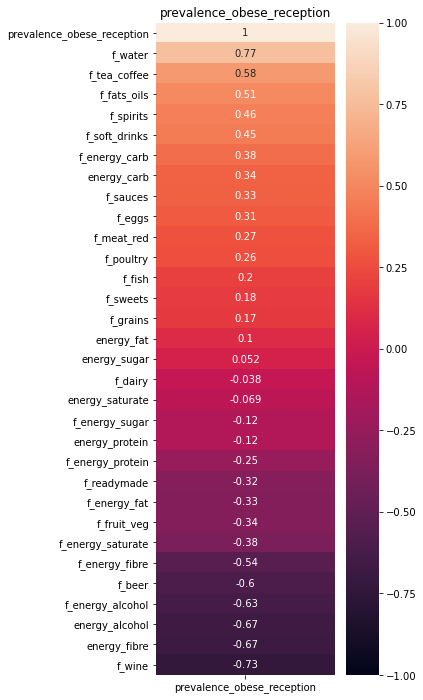

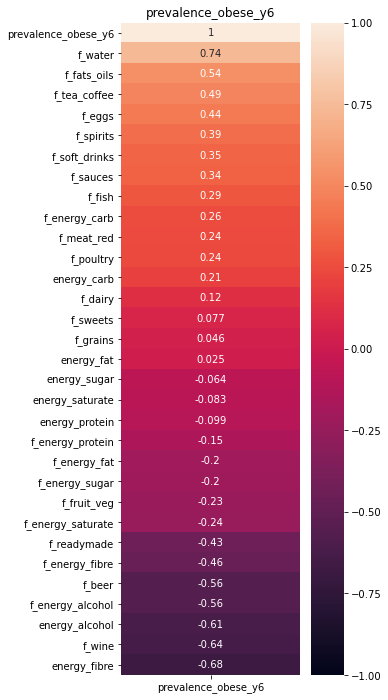

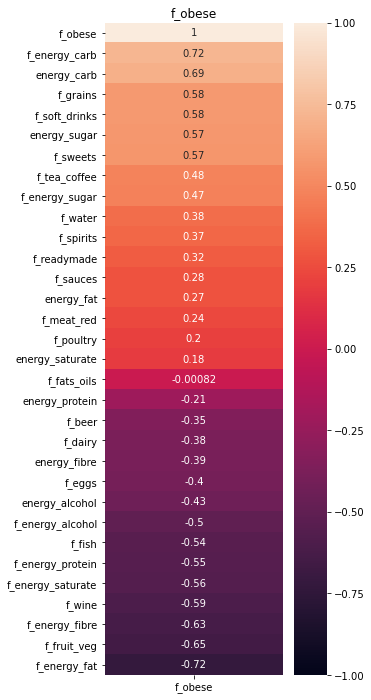

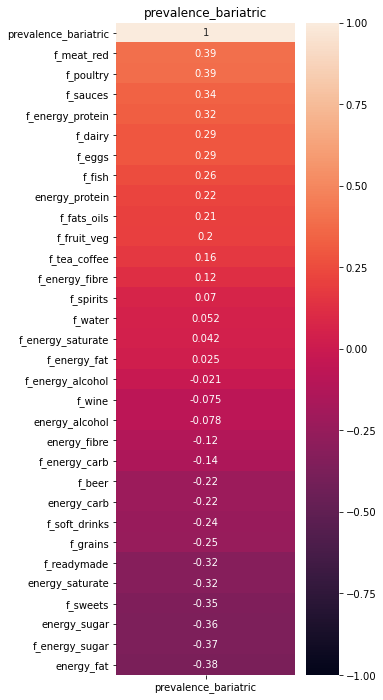

In [16]:
for ind in indicators :
    plt.figure(figsize=(4, 12))
    labels = features.copy()
    labels.append(ind)
    #print(labels)
    df = merged_borough[labels]
    #mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    #print(merged_borough)
    #print(df.corr()[ind].sort_values(ascending=False).shape)
    #data = np.asarray(df.corr()[ind].sort_values(ascending=False)).reshape(8,1)
    heatmap = sns.heatmap(df.corr()[[ind]].sort_values(by = ind, ascending=False), vmin=-1, vmax=1, annot=True)
    heatmap.set_title(ind, fontdict={'fontsize':12})
    
    plt.show()

#### Visualize average diet

Plot nutrient and category repartition in average diet

In [17]:
average_nutrients = pd.DataFrame(groceries_ward.mean(axis = 0)[f_nutrients], columns = ['nutrient'])
average_categories = pd.DataFrame(groceries_ward.mean(axis = 0)[f_food_categories], columns = ['category'])

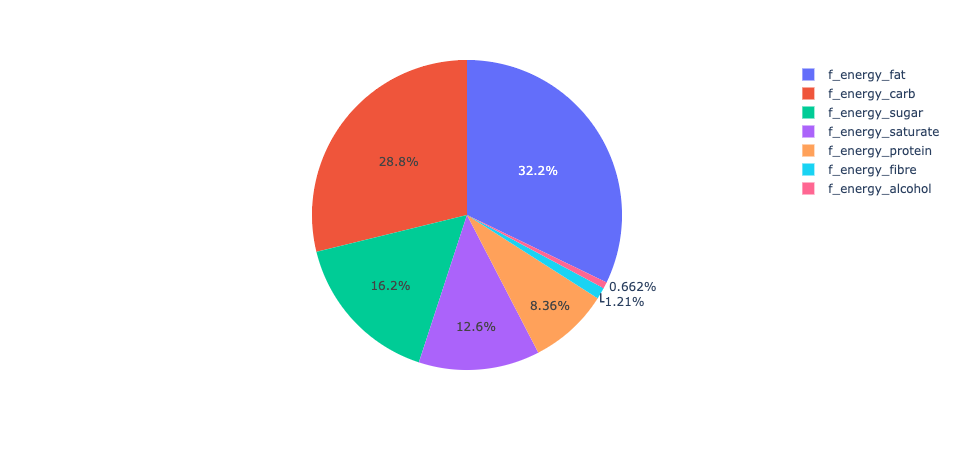

In [18]:
fig = px.pie(data_frame = average_nutrients, values = 'nutrient', names = average_nutrients.index)
fig.show()

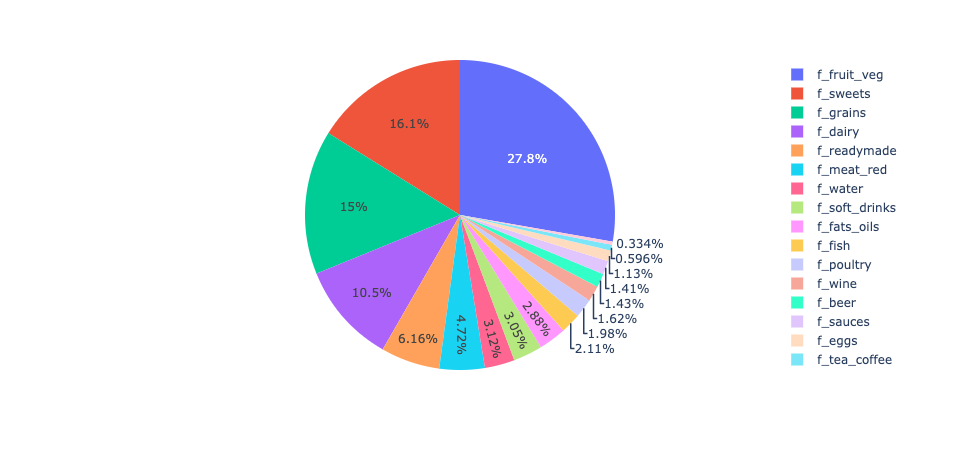

In [19]:
fig = px.pie(data_frame = average_categories, values = 'category', names = average_categories.index)
fig.show()

### Compute diet score

Method 1 : use correlation coefficients with diabetes

In [21]:
correlation = pd.DataFrame(columns = ['feature', 'R', 'p_value'])
for f in features:
    corr = stats.spearmanr(merged_ward['estimated_diabetes_prevalence'],merged_ward[f])
    corr_data = pd.DataFrame([[f, corr[0], corr[1]]], columns = ['feature', 'R', 'p_value'])
    correlation = correlation.append(corr_data, ignore_index = True)
sig_features = correlation[correlation['p_value'] < 1e-3]

In [22]:
def score(area):
    f = sig_features['feature'].values
    df = area[f].values
    weights = sig_features[['R']].values

    score = (df*weights).sum()
    return score

In [23]:
groceries_borough['score'] = groceries_borough.apply(score, axis=1)
scaler = MinMaxScaler()
groceries_borough['score'] = scaler.fit_transform(groceries_borough[['score']].values.reshape(-1,1))

Check consistency : plot repartition of lowest and highest scoring area

In [24]:
lowest = pd.DataFrame(groceries_borough[groceries_borough['score'] == 1][sig_features['feature'].values]).T
lowest.columns = ['nutrient']
highest = pd.DataFrame(groceries_borough[groceries_borough['score'] == 0][sig_features['feature'].values]).T
highest.columns = ['nutrient']

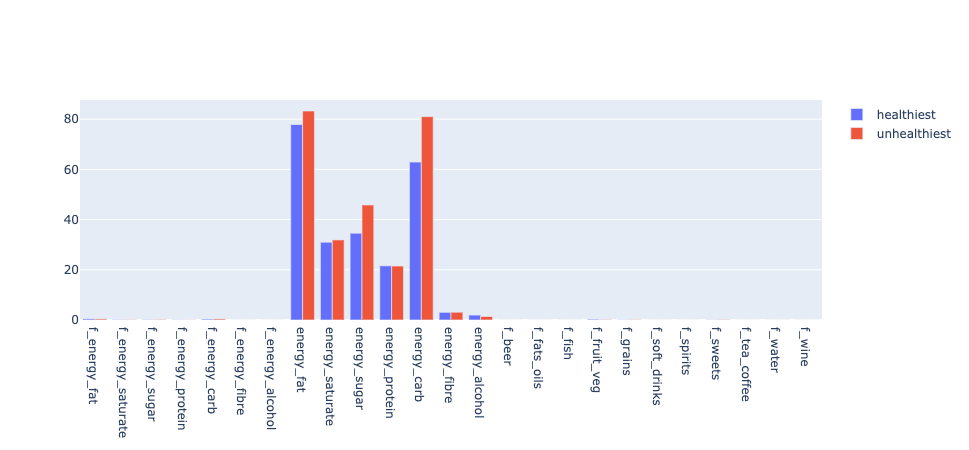

In [25]:
fig = go.Figure(data=[
    go.Bar(name='healthiest', x= lowest.index, y=lowest['nutrient']),
    go.Bar(name='unhealthiest', x= highest.index, y= highest['nutrient'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

Method 2 : fit a linear regression between features and several nutrition-related diseases and average the weights to compute the score

In [26]:
def find_weights(merged, label):
    X = merged[features]
    y = merged[label]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    hyperparams = {'reg':[0.1, 0.01, 0.001, 0.0001], 'learning_rate':[0.1, 0.05, 0.01]}
    scenarios = []
    for lr in hyperparams['learning_rate']:
        for r in hyperparams['reg']:
            scores = cross_validate(SGDRegressor(alpha = r, eta0 = lr),X, y = y, cv = 3,
                             scoring=('explained_variance', 'neg_mean_squared_error', 'r2'))
            scenario = {'learning_rate':lr, 'regularizer':r,
                        'MSE': scores['test_neg_mean_squared_error'],
                        'Explained variance': scores['test_explained_variance'],
                       'r2' : scores['test_r2']}
            #print(scores)
            scenarios.append(scenario)

    best = np.argmax([np.mean(s['r2']) for s in scenarios])

    reg_opt = scenarios[best]['regularizer']
    lr_opt = scenarios[best]['learning_rate']
    print(reg_opt, lr_opt)
    model_opt = SGDRegressor(eta0 = lr_opt, alpha = reg_opt)
    model_opt.fit(X,y)
    r2 = model_opt.score(X, y)
    train_error = np.mean((model_opt.predict(X)-y)**2)
    print(label)
    print(("Training error : {}, R2 : {}").
          format(train_error, r2))
    return model_opt.coef_

In [27]:
#validation_ward = ['estimated_diabetes_prevalence', 'prevalence_obese_reception', 'prevalence_obese_y6']
#validation_borough = ['f_obese']
#for label in validation_ward:
    #weights[label] = find_weights(merged_ward, label)

#for label in validation_borough:
    #weights[label] = find_weights(merged_borough, label)

We compute the optimal weights of features for each nutritional-related disease.

In [28]:
weights = pd.DataFrame(index = features, columns = indicators)

for label in indicators:
    weights[label] = find_weights(merged_borough, label)

0.1 0.05
estimated_diabetes_prevalence
Training error : 0.12690593388446456, R2 : 0.9431835298172123
0.0001 0.05
prevalence_obese_reception
Training error : 0.00010466170188193557, R2 : 0.6314712522940424
0.01 0.1
prevalence_obese_y6
Training error : 0.0008685416687331494, R2 : 0.19004001648138058
0.1 0.05
f_obese
Training error : 5.1539811554738115, R2 : 0.7625877488470205
0.0001 0.05
prevalence_bariatric
Training error : 1.2220842643612857e-05, R2 : 0.4242602531826406


We average the weights for all diseases.

In [29]:
weights['average'] = weights.mean(axis = 1)

Problem : Optimal hyperparameters keep changing through runs. Maybe due to small data?
Also, for now we select best hyper-param according to r2 score. should maybe change?

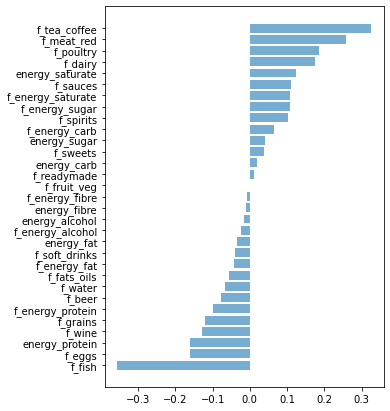

In [30]:
weights = weights.sort_values("average")
plt.subplots(figsize=(5,7))
plt.barh(weights.index, weights.average, alpha=0.6)
plt.show()

In [31]:
def score1(area):

    df = area[features].values
    w = weights['average'].values

    score = (df*w).sum()
    return score

groceries_borough['score'] = groceries_borough.apply(score1, axis=1)

#Scale score between 0 and 1
scaler = MinMaxScaler()
groceries_borough['score'] = scaler.fit_transform(groceries_borough[['score']].values.reshape(-1,1))

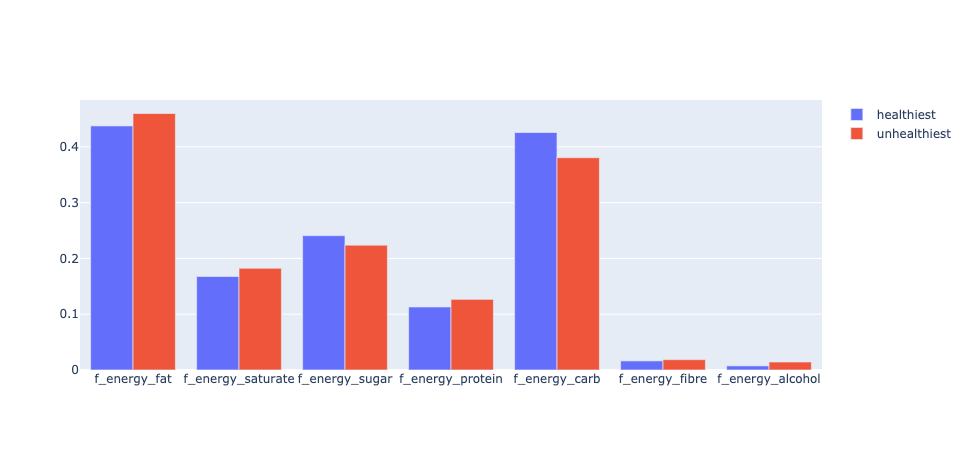

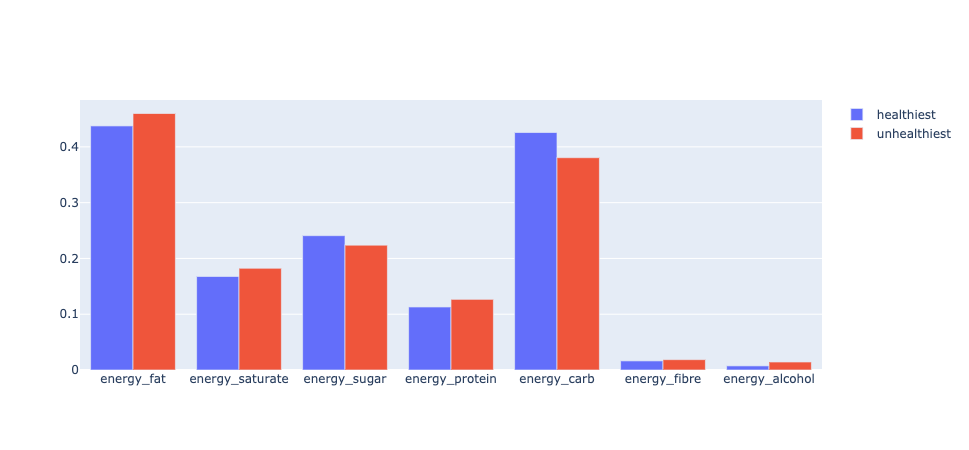

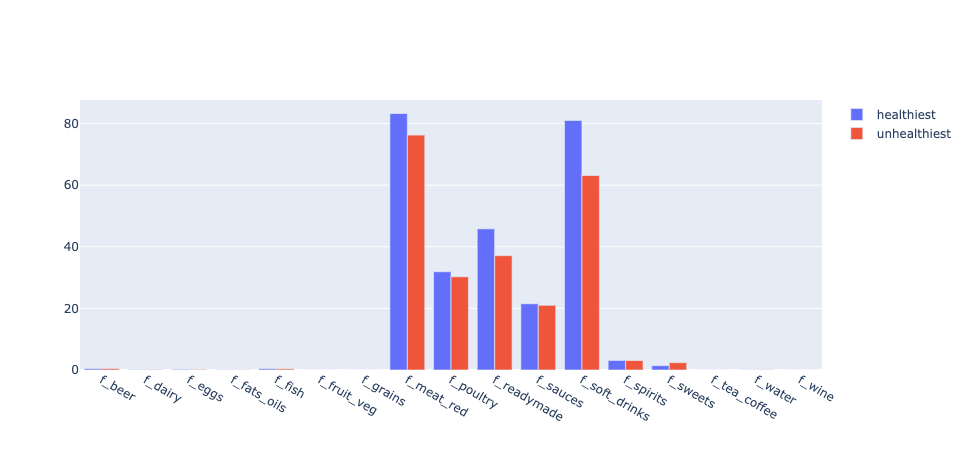

In [32]:
# Score of 1 means unhealthy
highest = pd.DataFrame(groceries_borough[groceries_borough['score'] == 1][features]).T
highest.columns = ['nutrient']
lowest = pd.DataFrame(groceries_borough[groceries_borough['score'] == 0][features]).T
lowest.columns = ['nutrient']
fig = go.Figure(data=[
    go.Bar(name='healthiest', x= f_nutrients, y=lowest['nutrient']),
    go.Bar(name='unhealthiest', x= f_nutrients, y= highest['nutrient'])
])
fig.update_layout(barmode='group')
fig.show()

fig = go.Figure(data=[
    go.Bar(name='healthiest', x= energy_nutrients, y=lowest['nutrient']),
    go.Bar(name='unhealthiest', x= energy_nutrients, y= highest['nutrient'])
])
fig.update_layout(barmode='group')
fig.show()

fig = go.Figure(data=[
    go.Bar(name='healthiest', x= f_food_categories, y=lowest['nutrient']),
    go.Bar(name='unhealthiest', x= f_food_categories, y= highest['nutrient'])
])
fig.update_layout(barmode='group')
fig.show()

Possible improvements:
- feature selection (based on correlation on top)
- label selection (maybe remove some indicators)

### Map viz

In [ ]:
plot_london('score', groceries_borough)